In [6]:
import pandas as pd
from PIL import Image

from dataclasses import dataclass

import torch
from torch.utils.data import Dataset
from pathlib import Path

from typing import List, Tuple

In [7]:
data_dir = "data"

chat_file = Path(data_dir).joinpath("chat.json")
chat_data = pd.read_json(chat_file)

# chat_data.shape
chat_data.head(n = 10)

,id,image,conversations
0,GCC_train_002582585,GCC_train_002582585.jpg,"[{'from': 'human', 'value': 'Provide a brief d..."
1,GCC_train_002429825,GCC_train_002429825.jpg,"[{'from': 'human', 'value': '<image> Write a t..."
2,GCC_train_000190697,GCC_train_000190697.jpg,"[{'from': 'human', 'value': 'Share a concise i..."
3,GCC_train_002503829,GCC_train_002503829.jpg,"[{'from': 'human', 'value': 'Relay a brief, cl..."
4,GCC_train_000530863,GCC_train_000530863.jpg,"[{'from': 'human', 'value': '<image> Render a ..."
5,GCC_train_001970366,GCC_train_001970366.jpg,"[{'from': 'human', 'value': 'Create a compact ..."
6,GCC_train_001885390,GCC_train_001885390.jpg,"[{'from': 'human', 'value': '<image> Render a ..."
7,GCC_train_001764002,GCC_train_001764002.jpg,"[{'from': 'human', 'value': '<image> Give a sh..."
8,GCC_train_002554598,GCC_train_002554598.jpg,"[{'from': 'human', 'value': 'Create a compact ..."
9,GCC_train_001948583,GCC_train_001948583.jpg,"[{'from': 'human', 'value': '<image> Summarize..."


### Extract the images

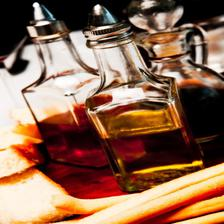

In [8]:
image_dir = Path(data_dir).joinpath("images")
    
test_image_file = image_dir.joinpath(chat_data.iloc[0]['image'])

Image.open(test_image_file)

### Extract the QA pairs

In [9]:
q = chat_data.iloc[0]['conversations'][0]['value']
a = chat_data.iloc[0]['conversations'][1]['value']

q, a

('Provide a brief description of the given image.\n<image>',
 'olive oil is a healthy ingredient used liberally .')

## Create the Dataset

In [10]:
class LlavaDataset0(Dataset):
    def __init__(self, chat_data, image_dir):
        self.chat_data = chat_data
        self.image_dir = image_dir
        
    def __len__(self):
        return len(self.chat_data)
    
    def __getitem__(self, idx):
        image_file = self.image_dir.joinpath(self.chat_data.iloc[idx]['image'])
        q = self.chat_data.iloc[idx]['conversations'][0]['value']
        a = self.chat_data.iloc[idx]['conversations'][1]['value']
        
        return image_file, q, a

In [11]:
class LlavaDataset(Dataset):
    def __init__(self, data_dir:str):
        super().__init__()

        self.chat_data, self.image_dir = self.build_dataset(data_dir)

    def build_dataset(self, data_dir:str) -> tuple[dict, Path]:
        data_dir = Path(data_dir)
        chat_file = data_dir.joinpath("chat.json")
        image_dir = data_dir.joinpath("images")

        chat_data = pd.read_json(chat_file).to_dict(orient='records')

        return chat_data, image_dir

    def __len__(self):
        return len(self.chat_data)

    
    def __getitem__(self, idx:int) -> Tuple[str, str, Path]:
        cur_data = self.chat_data[idx]
        human_input = cur_data['conversations'][0]['value']
        gpt_output = cur_data['conversations'][1]['value']

        image_file = self.image_dir.joinpath(cur_data['image'])
        
        return (human_input, gpt_output, image_file)
    

test_llavadataset = LlavaDataset(data_dir)

Length of dataset:  595375 

('Describe the image concisely.\n<image>', 'illustration of a gray goose on a white background', PosixPath('data/images/GCC_train_002160298.jpg')) 



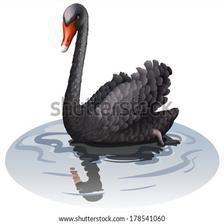

In [12]:
print("Length of dataset: ", len(test_llavadataset), "\n")

print(test_llavadataset[12345], "\n")

Image.open(test_llavadataset[12345][2])

## Collator

In [43]:
from transformers import AutoProcessor

llava_model_name_or_path = "my-model/model-01"
llava_processor = AutoProcessor.from_pretrained(llava_model_name_or_path)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Qwen2Tokenizer'. 
The class this function is called from is 'CLIPTokenizerFast'.


In [14]:
test02 = test_llavadataset[12345]
test02

('Describe the image concisely.\n<image>',
 'illustration of a gray goose on a white background',
 PosixPath('data/images/GCC_train_002160298.jpg'))

In [36]:
from dataclasses import dataclass

@dataclass
class QAIoutput:
    q_input_ids: torch.Tensor
    a_input_ids: torch.Tensor
    pixel_values: torch.Tensor

def build_qai(processor: AutoProcessor, q:str, a:str, image_path:Path) -> dict:
    # ? 1. instruction or input or question
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": q}
    ]
    prompt = processor.tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    # ? 2. Image
    image_file = image_path
    raw_image = Image.open(image_file)

    # ? (1 & 2) together
    inputs = processor(prompt, raw_image, return_tensors="pt")

    # ? 3. Answer
    a_input_ids = processor.tokenizer(
        a, 
        return_tensors="pt",
        padding="longest",
        truncation=True,
    ).input_ids

    # ? 4. Return
    return QAIoutput(
        q_input_ids = inputs["input_ids"],
        a_input_ids = a_input_ids,
        pixel_values = inputs["pixel_values"]
    )

c = build_qai(llava_processor, test02[0], test02[1], test02[2])
c

QAIoutput(q_input_ids=tensor([[151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
         151645,    198, 151644,    872,    198,  74785,    279,   2168,   3529,
            285,    974,    624, 151646, 151645,    198, 151644,  77091,    198]]), a_input_ids=tensor([[82618,   367,   315,   264, 17545, 62137,   389,   264,  4158,  4004]]), pixel_values=tensor([[[[1.9011, 1.9011, 1.9011,  ..., 1.9011, 1.9011, 1.9011],
          [1.9011, 1.9011, 1.9011,  ..., 1.9011, 1.9011, 1.9011],
          [1.9157, 1.9157, 1.9157,  ..., 1.9157, 1.9157, 1.9157],
          ...,
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303]],

         [[2.0449, 2.0449, 2.0449,  ..., 2.0449, 2.0449, 2.0449],
          [2.0449, 2.0449, 2.0449,  ..., 2.0449, 2.0449, 2.0449],
          [2.0599, 2.0599, 2.0599,  ..., 2.0599, 2.0599, 2.0599],
          ...,

In [33]:
print("Tokenized input: ", c['input_ids'][0], "\n")
print("===============================\n")
print("Decode the input_ids: \n")
print("===============================\n")
print(llava_processor.tokenizer.decode(c['input_ids'][0]))
print("===============================\n")

c['pixel_values'].shape

Tokenized input:  tensor([151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
        151645,    198, 151644,    872,    198,  74785,    279,   2168,   3529,
           285,    974,    624, 151646, 151645,    198, 151644,  77091,    198]) 


Decode the input_ids: 


<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
Describe the image concisely.
<image><|im_end|>
<|im_start|>assistant




torch.Size([1, 3, 336, 336])

In [ ]:
q = [101, 102, 103]
a = [201, 202, 203, 204]

input_ids = [101, 102, 103, 201, 202, 203, 204, 'eos_id']
labels = [-100, -100, -100, 201, 202, 203, 204, 'eos_id']

In [46]:
print(c.q_input_ids.shape)
print(c.a_input_ids.shape)
print(torch.tensor(llava_processor.tokenizer.eos_token_id).reshape(1, -1).shape)

torch.Size([1, 27])
torch.Size([1, 10])
torch.Size([1, 1])


In [80]:
class TrainLlavaCollator:
    def __init__(self, processor: AutoProcessor, IGNORE_IDX: int):
        self.processor = processor
        self.ignore_idx = IGNORE_IDX

    def convert_one_piece(self, 
                        q_input_ids: torch.Tensor,
                        a_input_ids: torch.Tensor) -> dict:
        input_ids= torch.cat([
            q_input_ids, 
            a_input_ids,
            torch.tensor(self.processor.tokenizer.eos_token_id).reshape(1, -1)
            ], dim=1)
        labels = torch.cat([
            torch.full_like(q_input_ids, self.ignore_idx),
            a_input_ids,
            torch.tensor(self.processor.tokenizer.eos_token_id).reshape(1, -1)
            ], dim=1)

        return input_ids, labels


    def __call__(self, features: List) -> dict:
        input_ids_list = []
        labels_list = []
        pixel_values_list = []
        max_input_len_list = []

        for feature in features:
            qai_output = build_qai(
                processor=self.processor, 
                q=feature[0], a=feature[1], image_path=feature[2]
            )
            tmp_input_ids, tmp_labels = self.convert_one_piece(
                qai_output.q_input_ids, 
                qai_output.a_input_ids
            )
            max_input_len_list.append(tmp_input_ids.shape[1])
            input_ids_list.append(tmp_input_ids)
            labels_list.append(tmp_labels)
            pixel_values_list.append(qai_output.pixel_values)

        max_input_len = max(max_input_len_list)

        final_input_ids = torch.cat([
            torch.cat([
                torch.full(
                    size=(1, max_input_len - input_ids.shape[1]), 
                    fill_value=self.processor.tokenizer.pad_token_id
                ),
                input_ids
            ], dim=1) for input_ids in input_ids_list
        ], dim=0)

        final_labels = torch.cat([
            torch.cat([
                torch.full(
                    size=(1, max_input_len - labels.shape[1]), 
                    fill_value=self.ignore_idx
                ),
                labels
            ], dim=1) for labels in labels_list
        ], dim=0)

        final_pixel_values = torch.cat(pixel_values_list, dim=0)

        attention_mask = torch.ones_like(final_input_ids)
        attention_mask[final_input_ids == self.processor.tokenizer.pad_token_id] = 0 
        

        return {
            "input_ids": final_input_ids,
            "labels": final_labels,
            "pixel_values": final_pixel_values,
            "attention_mask": attention_mask,
        }

tlmc = TrainLlavaCollator(llava_processor, -100)

In [81]:
# tlmc.convert_one_piece(c.q_input_ids, c.a_input_ids, c.pixel_values)

d = tlmc([test_llavadataset[1], test_llavadataset[2], test_llavadataset[3]])

In [82]:
d.keys()

dict_keys(['input_ids', 'labels', 'pixel_values', 'attention_mask'])

In [85]:
d['input_ids']

tensor([[151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151643, 151644,   8948,    198,   2610,    525,    264,  10950,
          17847,     13, 151645,    198, 151644,    872,    198, 151646,    198,
           7985,    264,  50537,    714,  38219,  12126,    315,    279,   6802,
             13, 151645,    198, 151644,  77091,    198,     18,     67,   4621,
          78424,  27790,    315,  26618,  45620,  15430,  20748,  17738,    659,
         151645],
        [151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151643, 151643, 151643, 151643, 151644,   8948,    198,   2610,
            525,    264,  10950,  17847,     13, 151645,    198, 151644,    872,
            198,  12115,    264,  63594,  22845,    315,    279,   2168,   3897,
            624, 151646, 151645,    198, 151644,  77091,    198,  15206,    287,
           1177,    279,   6961,    609,  11483,  29985,    315,  23035,    659,
         1

In [84]:
d['attention_mask']

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1]])

## Verification

In [88]:
from transformers import LlavaForConditionalGeneration

llava_model_name_or_path = "my-model/model-01"
llava_processor = AutoProcessor.from_pretrained(llava_model_name_or_path)

llava_model = LlavaForConditionalGeneration.from_pretrained(llava_model_name_or_path, torch_dtype=torch.bfloat16, device_map='cuda')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Qwen2Tokenizer'. 
The class this function is called from is 'CLIPTokenizerFast'.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [89]:
for tk in d.keys():
    d[tk] = d[tk].to(llava_model.device)

model_outputs = llava_model(**d)

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


In [90]:
model_outputs

LlavaCausalLMOutputWithPast(loss=tensor(8.7173, device='cuda:0', dtype=torch.float32,
       grad_fn=<NllLossBackward0>), logits=tensor([[[-0.2344, -1.2812, -2.7188,  ...,  2.2344,  2.2344,  2.2344],
         [-0.2344, -1.2812, -2.7188,  ...,  2.2344,  2.2344,  2.2344],
         [-0.2344, -1.2812, -2.7188,  ...,  2.2344,  2.2344,  2.2344],
         ...,
         [ 2.4219,  4.6250, -1.6250,  ..., -4.0000, -4.0000, -4.0000],
         [ 0.8125,  1.7812, -0.7734,  ..., -2.1094, -2.1094, -2.1094],
         [ 2.7344,  5.3125, -0.4746,  ..., -1.4609, -1.4609, -1.4609]],

        [[-0.6875, -2.5156, -5.2812,  ...,  0.5234,  0.5234,  0.5273],
         [-0.6875, -2.5156, -5.2812,  ...,  0.5234,  0.5234,  0.5273],
         [-0.6875, -2.5156, -5.2812,  ...,  0.5234,  0.5234,  0.5273],
         ...,
         [ 5.0625,  5.3438,  0.2090,  ..., -3.8438, -3.8438, -3.8438],
         [ 0.7852,  2.2500, -0.7852,  ..., -3.2344, -3.2188, -3.2188],
         [ 1.3516,  4.2188, -2.1094,  ..., -2.0469, -2.0469,